In [1]:
# imports: 
import numpy as np
import pandas as pd
import wrangle as wr

# feature selection: 
from sklearn.feature_selection import SelectKBest, \
RFE, f_regression, SequentialFeatureSelector

from sklearn.linear_model import LinearRegression


import warnings
warnings.filterwarnings("ignore")


#new imports
from sklearn.tree import DecisionTreeClassifier
from sklearn.metrics import classification_report, confusion_matrix

In [2]:
# acquire the data: 
df = wr.acquire_water()

In [3]:
# prep the data:
df = wr.prep_water(df)

In [4]:
# split the data
train, validate, test = wr.split_water(df)

In [5]:
# split data in X_train, and y_train
X_train = train.drop(columns = 'potability')
y_train = train[['potability']]

X_validate = validate.drop(columns = 'potability')
y_validate = validate[['potability']]

X_test = test.drop(columns = 'potability')
y_test = test[['potability']]

# Feature Engineering:

In [6]:
# Select K-best: 
kbest = SelectKBest(f_regression, k = 2)

# fit the thing: 
kbest.fit(X_train, y_train)

SelectKBest(k=2, score_func=<function f_regression at 0x13fadefc0>)

In [7]:
# statiscal f-value / featurer's scores:
kbest.scores_

array([0.28089469, 0.54203547, 1.67963804, 3.37603307, 0.44668075,
       1.84300057, 0.28437023, 0.10380437, 0.0244078 ])

In [8]:
# p value: 
kbest.pvalues_

array([0.59622017, 0.46174414, 0.19523884, 0.06641518, 0.50405279,
       0.1748724 , 0.59395653, 0.7473711 , 0.87587985])

In [9]:
# get the names of the features its looking at: 
kbest.feature_names_in_

array(['ph', 'hardness', 'solids', 'chloramines', 'sulfate',
       'conductivity', 'organic_carbon', 'trihalomethanes', 'turbidity'],
      dtype=object)

In [10]:
kbest_results = pd.DataFrame(
                dict(p=kbest.pvalues_, f=kbest.scores_),
                                        index = X_train.columns)

In [11]:
kbest_results

,p,f
ph,0.596220,0.280895
hardness,0.461744,0.542035
solids,0.195239,1.679638
chloramines,0.066415,3.376033
sulfate,0.504053,0.446681
conductivity,0.174872,1.843001
organic_carbon,0.593957,0.284370
trihalomethanes,0.747371,0.103804
turbidity,0.875880,0.024408


In [12]:
#RFE:
model = LinearRegression()

In [13]:
# make it: 
rfe = RFE(model, n_features_to_select= 2)

# Fit the thing:
rfe.fit(X_train, y_train)

RFE(estimator=LinearRegression(), n_features_to_select=2)

In [14]:
# get the feature ranking:
rfe.ranking_

array([1, 4, 8, 1, 5, 7, 3, 6, 2])

In [15]:
# make a dataframe of the rankings for better understanding
pd.DataFrame(
{
    'rfe_ranking':rfe.ranking_
}, index = X_train.columns)

,rfe_ranking
ph,1
hardness,4
solids,8
chloramines,1
sulfate,5
conductivity,7
organic_carbon,3
trihalomethanes,6
turbidity,2


In [16]:
#SFS
model = LinearRegression()

# MAKE the thing
sfs = SequentialFeatureSelector(model, n_features_to_select=2)

# FIT the thing
sfs.fit(X_train, y_train)

SequentialFeatureSelector(estimator=LinearRegression(), n_features_to_select=2)

In [17]:
sfs.support_

array([False, False, False,  True, False,  True, False, False, False])

In [18]:
X_train_SFStransformed = pd.DataFrame(
                            sfs.transform(X_train),
                            index = X_train.index,
                            columns = X_train.columns[sfs.support_])

In [19]:
X_train_SFStransformed.head()

,chloramines,conductivity
2719,5.57,421.66
3230,8.74,318.64
1502,7.41,522.55
978,6.19,452.45
1114,3.37,300.41


# Modeling: 
- Decision Tree
- Random Forest

In [20]:
# The mode is a great baseline
baseline = y_train.mode()

# Produce a boolean array with True representing a match between the baseline prediction and reality
matches_baseline_prediction = y_train == 0

baseline_accuracy = matches_baseline_prediction.mean()
print(f"Baseline accuracy: {round(baseline_accuracy, 2)}")

Baseline accuracy: potability    0.6
dtype: float64


#run the decision tree with only three freatures: 
X_train = train[['ph','hardness','turbidity']]
y_train = train[['potability']]

X_validate = validate[['ph','hardness','turbidity']]
y_validate = validate[['potability']]

In [21]:
# lets run decision tree with all the columns first: 
clf = DecisionTreeClassifier(max_depth=3, random_state=123)
# Now let's train our model on the training data
clf = clf.fit(X_train, y_train)

In [22]:
# Now let's train our model on the training data
clf = clf.fit(X_train, y_train)

In [23]:
clf.predict(X_train)[:5]

array([1, 0, 0, 0, 1])

In [24]:
clf.score(X_train, y_train)

0.6435555555555555

In [25]:
y_pred = clf.predict(X_train)

In [26]:
conf = confusion_matrix(y_train, y_pred)
conf

array([[666,   6],
       [395,  58]])

In [27]:
pd.DataFrame(conf)


,0,1
0,666,6
1,395,58


In [28]:
print(classification_report(y_train, y_pred))

              precision    recall  f1-score   support

           0       0.63      0.99      0.77       672
           1       0.91      0.13      0.22       453

    accuracy                           0.64      1125
   macro avg       0.77      0.56      0.50      1125
weighted avg       0.74      0.64      0.55      1125



In [29]:
conf.ravel()

array([666,   6, 395,  58])

In [30]:
TN, FP, FN, TP = conf.ravel()
TN, FP, FN, TP

(666, 6, 395, 58)

In [31]:
all_ = (TP + TN + FP + FN)

accuracy = (TP + TN) / all_

TPR = recall = TP / (TP + FN)
FPR = FP / (FP + TN)

TNR = TN / (FP + TN)
FNR = FN / (FN + TP)

precision =  TP / (TP + FP)
f1 =  2 * ((precision * recall) / ( precision + recall))

support_pos = TP + FN
support_neg = FP + TN

In [32]:
print(f"Accuracy: {accuracy}\n")
print(f"True Positive Rate/Sensitivity/Recall/Power: {TPR}")
print(f"False Positive Rate/False Alarm Ratio/Fall-out: {FPR}")
print(f"True Negative Rate/Specificity/Selectivity: {TNR}")
print(f"False Negative Rate/Miss Rate: {FNR}\n")
print(f"Precision/PPV: {precision}")
print(f"F1 Score: {f1}\n")
print(f"Support (0): {support_pos}")
print(f"Support (1): {support_neg}")

Accuracy: 0.6435555555555555

True Positive Rate/Sensitivity/Recall/Power: 0.1280353200883002
False Positive Rate/False Alarm Ratio/Fall-out: 0.008928571428571428
True Negative Rate/Specificity/Selectivity: 0.9910714285714286
False Negative Rate/Miss Rate: 0.8719646799116998

Precision/PPV: 0.90625
F1 Score: 0.2243713733075435

Support (0): 453
Support (1): 672


In [33]:
#for lots
for x in range(1,20):
#     print(x)
    clf = DecisionTreeClassifier(max_depth=x)
    clf.fit(X_train, y_train)
    acc = clf.score(X_train, y_train)
    print(f'for depth of {x:2}, the accuracy is {round(acc,2)}')

for depth of  1, the accuracy is 0.62
for depth of  2, the accuracy is 0.64
for depth of  3, the accuracy is 0.64
for depth of  4, the accuracy is 0.68
for depth of  5, the accuracy is 0.71
for depth of  6, the accuracy is 0.73
for depth of  7, the accuracy is 0.74
for depth of  8, the accuracy is 0.75
for depth of  9, the accuracy is 0.78
for depth of 10, the accuracy is 0.81
for depth of 11, the accuracy is 0.85
for depth of 12, the accuracy is 0.87
for depth of 13, the accuracy is 0.89
for depth of 14, the accuracy is 0.9
for depth of 15, the accuracy is 0.92
for depth of 16, the accuracy is 0.93
for depth of 17, the accuracy is 0.94
for depth of 18, the accuracy is 0.95
for depth of 19, the accuracy is 0.97


In [34]:
scores_all = []

for x in range(1,20):

    clf = DecisionTreeClassifier(max_depth=x)
    clf.fit(X_train, y_train)
    train_acc = clf.score(X_train, y_train)
    
    #evaluate on validate
    val_acc = clf.score(X_validate, y_validate)
    
    scores_all.append([x, train_acc, val_acc])

In [35]:
scores_df = pd.DataFrame(scores_all, columns=['max_depth','train_acc','val_acc'])
scores_df.head()

,max_depth,train_acc,val_acc
0,1,0.624889,0.602484
1,2,0.639111,0.614907
2,3,0.643556,0.612836
3,4,0.680889,0.621118
4,5,0.708444,0.637681


In [36]:
scores_df['diff'] = scores_df.train_acc - scores_df.val_acc

In [37]:
scores_df.sort_values('diff')

,max_depth,train_acc,val_acc,diff
0,1,0.624889,0.602484,0.022404
1,2,0.639111,0.614907,0.024204
2,3,0.643556,0.612836,0.030719
3,4,0.680889,0.621118,0.059771
4,5,0.708444,0.637681,0.070763
5,6,0.726222,0.621118,0.105104
6,7,0.737778,0.623188,0.114589
7,8,0.745778,0.619048,0.126730
8,9,0.780444,0.596273,0.184171
9,10,0.812444,0.604555,0.207890


# Random Forest: 

In [38]:
# imports 
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import classification_report
from sklearn.metrics import confusion_matrix

In [39]:
from sklearn.metrics import ConfusionMatrixDisplay

In [40]:
# The mode is a great baseline
baseline = y_train.mode()

# Produce a boolean array with True representing a match between the baseline prediction and reality
matches_baseline_prediction = y_train == 0

baseline_accuracy = matches_baseline_prediction.mean()
print(f"Baseline accuracy: {round(baseline_accuracy, 2)}")

Baseline accuracy: potability    0.6
dtype: float64


In [41]:
# Make the model
forest1 = RandomForestClassifier(max_depth=1, random_state=123)

# Fit the model (on train and only train)
forest1.fit(X_train, y_train)

# Use the model
# We'll evaluate the model's performance on train, first
y_predictions = forest1.predict(X_train)

# Produce the classification report on the actual y values and this model's predicted y values
report = classification_report(y_train, y_predictions, output_dict=True)
print("Tree of 1 depth")
pd.DataFrame(report)

Tree of 1 depth


,0,1,accuracy,macro avg,weighted avg
precision,0.602334,0.909091,0.605333,0.755712,0.725855
recall,0.998512,0.022075,0.605333,0.510293,0.605333
f1-score,0.751400,0.043103,0.605333,0.397252,0.466192
support,672.000000,453.000000,0.605333,1125.000000,1125.000000


In [42]:
# sklearn confusion matrix
pd.DataFrame(confusion_matrix(y_predictions, y_train))

,0,1
0,671,443
1,1,10


In [43]:
TN, FP, FN, TP = confusion_matrix(y_train,y_predictions).ravel()
ALL = TP + TN + FP + FN

TP, TN, FP, FN

(10, 671, 1, 443)

In [44]:
accuracy = (TP + TN)/ALL
print(f"Accuracy: {accuracy}")

true_positive_rate = TP/(TP+FN)
print(f"True Positive Rate: {true_positive_rate}")

false_positive_rate = FP/(FP+TN)
print(f"False Positive Rate: {false_positive_rate}")

true_negative_rate = TN/(TN+FP)
print(f"True Negative Rate: {true_negative_rate}")

false_negative_rate = FN/(FN+TP)
print(f"False Negative Rate: {false_negative_rate}")

precision = TP/(TP+FP)
print(f"Precision: {precision}")

recall = TP/(TP+FN)
print(f"Recall: {recall}")

f1_score = 2*(precision*recall)/(precision+recall)
print(f"F1 Score: {f1_score}")

support_pos = TP + FN
print(f"Support (0): {support_pos}")

support_neg = FP + TN
print(f"Support (1): {support_neg}")

Accuracy: 0.6053333333333333
True Positive Rate: 0.02207505518763797
False Positive Rate: 0.001488095238095238
True Negative Rate: 0.9985119047619048
False Negative Rate: 0.977924944812362
Precision: 0.9090909090909091
Recall: 0.02207505518763797
F1 Score: 0.04310344827586207
Support (0): 453
Support (1): 672


In [45]:
# Let's continue getting loopy, so we can compare in-sample to out-of-sample
metrics = []

for i in range(2, 25):
    # Make the model
    forest = RandomForestClassifier(max_depth=i, random_state=123)

    # Fit the model (on train and only train)
    forest = forest.fit(X_train, y_train)

    # Use the model
    # We'll evaluate the model's performance on train, first
    in_sample_accuracy = forest.score(X_train, y_train)
    
    out_of_sample_accuracy = forest.score(X_validate, y_validate)

    output = {
        "max_depth": i,
        "train_accuracy": in_sample_accuracy,
        "validate_accuracy": out_of_sample_accuracy
    }
    
    metrics.append(output)
    
df = pd.DataFrame(metrics)
df["difference"] = df.train_accuracy - df.validate_accuracy
df

,max_depth,train_accuracy,validate_accuracy,difference
0,2,0.648889,0.606625,0.042264
1,3,0.672889,0.612836,0.060052
2,4,0.689778,0.629400,0.060378
3,5,0.715556,0.627329,0.088226
4,6,0.744000,0.623188,0.120812
5,7,0.784889,0.633540,0.151349
6,8,0.828444,0.645963,0.182482
7,9,0.873778,0.641822,0.231956
8,10,0.904000,0.643892,0.260108
9,11,0.930667,0.627329,0.303337


In [46]:
import matplotlib.pyplot as plt

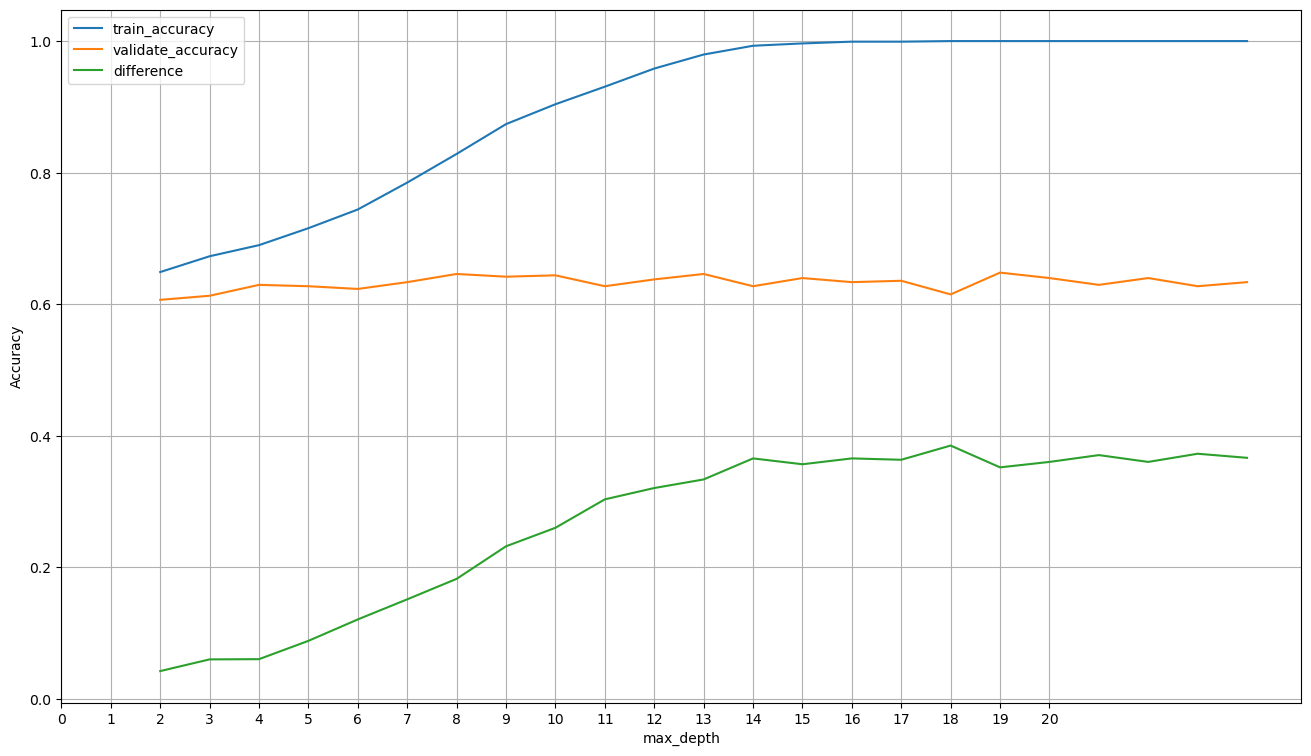

In [47]:
df.set_index('max_depth').plot(figsize = (16,9))
plt.ylabel('Accuracy')
plt.xticks(np.arange(0,21,1))
plt.grid()